<a href="https://colab.research.google.com/github/shauryasachdev/Deep-Learning/blob/main/Transformer_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_cpu==2.19.1
!pip install matplotlib==3.9.2

print("============ All Libraries Installed ===========")

============ All Libraries Installed ===========


In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [ ]:
# sample parallel sentences

input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]

target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

In [ ]:
# Next, we convert the text from the sentences to tokens and create a vocabulary

# Tokenization: Uses Tokenizer to convert words into numerical sequences.

#Tokenization

input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

print("The input tokenizer looks like: ", input_tokenizer)
print("The input text: ", input_texts, "\n is converted to the tokens:", input_sequences)
print("\n")


output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

print("The output tokenizer looks like: ", output_tokenizer)
print("The target text: ", target_texts, "\n is converted to the tokens:", output_sequences)
print("\n")

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

print("The input vocabulary size is: ", input_vocab_size)
print("The output vocabulary size is: ", output_vocab_size)

The input tokenizer looks like:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fb82aff06b0>
The input text:  ['Hello.', 'How are you?', 'I am learning machine translation.', 'What is your name?', 'I love programming.'] 
 is converted to the tokens: [[2], [3, 4, 5], [1, 6, 7, 8, 9], [10, 11, 12, 13], [1, 14, 15]]


The output tokenizer looks like:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fb8aed98740>
The target text:  ['startseq Hola. endseq', 'startseq ¿Cómo estás? endseq', 'startseq Estoy aprendiendo traducción automática. endseq', 'startseq ¿Cuál es tu nombre? endseq', 'startseq Me encanta programar. endseq'] 
 is converted to the tokens: [[1, 3, 2], [1, 4, 5, 2], [1, 6, 7, 8, 9, 2], [1, 10, 11, 12, 13, 2], [1, 14, 15, 16, 2]]


The input vocabulary size is:  16
The output vocabulary size is:  17


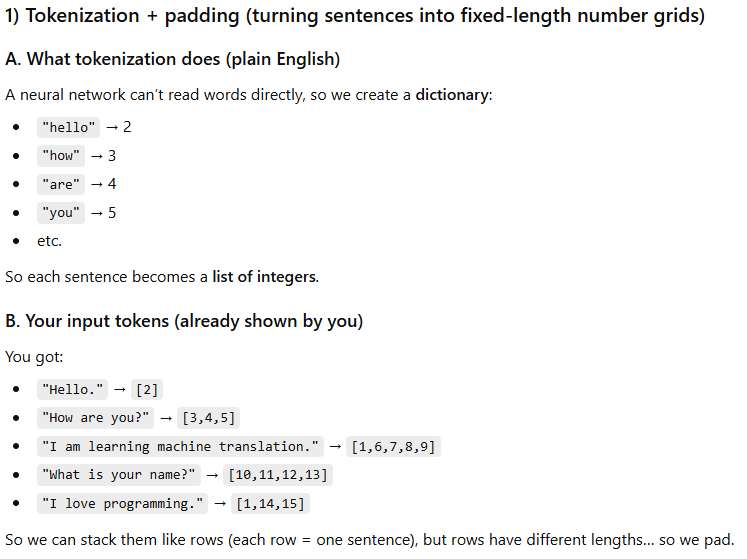

In [ ]:
# Padding the input and output sequences

max_input_length = max(len(seq) for seq in input_sequences)
max_output_length = max(len(seq) for seq in output_sequences)

print("Max Input Length: ", max_input_length)
print("Max Output Length: ", max_output_length)

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

print("\n")
print("The input sequences after padding: ", input_sequences)
print("The output sequences after padding: ", output_sequences)

Max Input Length:  5
Max Output Length:  6


The input sequences after padding:  [[ 2  0  0  0  0]
 [ 3  4  5  0  0]
 [ 1  6  7  8  9]
 [10 11 12 13  0]
 [ 1 14 15  0  0]]
The output sequences after padding:  [[ 1  3  2  0  0  0]
 [ 1  4  5  2  0  0]
 [ 1  6  7  8  9  2]
 [ 1 10 11 12 13  2]
 [ 1 14 15 16  2  0]]


In [ ]:
# Prepare the target data for training
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

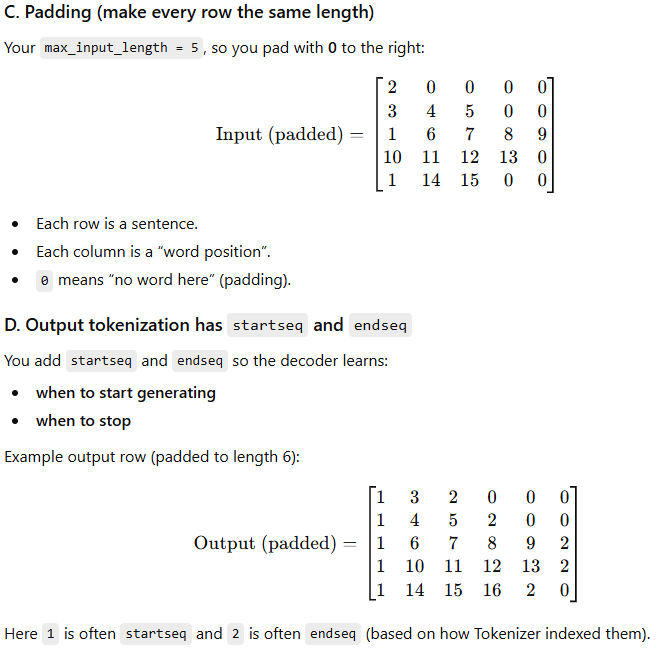



In [ ]:
# Define a special kind of layer for our neural network called SelfAttention

# This SelfAttention layer learns how to let each element in your input “look at”
# other elements and decide which ones matter more, then combines information accordingly.

#Think of your input as a row of items (words in a sentence, time steps in a
#signal, patches in an image). Attention helps each item say:
# “From all the other items, which should I pay attention to, and how much?”#

# Let's break down the SelfAttention class, line by line, focusing on the
# concepts of Query, Key, and Value, which are central to how self-attention works.

# The line below defines a custom neural network layer named SelfAttention.
# It inherits from Keras's Layer class, which provides the foundational structure for custom layers in Keras.

# This is the constructor method for your SelfAttention layer. It's called
# when you create an instance of the layer (e.g., attention_layer = SelfAttention()).


# super(): This function calls the constructor of the parent class, which is Layer in this case.
# init(**kwargs): This ensures that any initialization logic defined in
# the Layer base class is executed. It also allows you to pass any general
# keyword arguments (like name for the layer) to the parent constructor.
# Purpose: At this stage, the layer is simply initialized; no weights are
# created yet, as their dimensions depend on the input shape.

class SelfAttention(Layer):

  def __init__(self, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)

  def build(self, input_shape):
    # This method is called automatically by Keras the very first time the layer
    # receives data (i.e., when you first pass an input tensor to it).
    # Purpose: Its main job is to create the layer's weights based on the input_shape.

    feature_dim = input_shape[-1]
    # input_shape: This argument is a tuple representing the shape of the input data
    # that the layer expects. For example, if your input is a batch of sequences,
    # input_shape might be (batch_size, sequence_length, embedding_dimension).
    # [-1]: This extracts the last element of the input_shape tuple.
    # In most sequence processing tasks (like NLP with embeddings), this last dimension
    # represents the feature dimension or the embedding size of each element in the sequence.
    # This feature_dim determines the size of our Query, Key, and Value vectors.


    self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='glorot_uniform',
                              trainable=True,
                              name='Wq')

    self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='glorot_uniform',
                              trainable=True,
                              name='Wk')

    self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='glorot_uniform',
                              trainable=True,
                              name='Wv')


    # self.Wq/Wk/Wv: This creates a weight matrix specifically for transforming the input into a Query representation.
    # self.add_weight(): This is a Keras utility function to create a trainable weight variable for the layer.
    # shape=(feature_dim, feature_dim): This defines the shape of the weight matrix.
    # It's a square matrix, meaning it will transform an input vector of feature_dim
    # into an output vector also of feature_dim. This ensures that Query, Key, and Value
    # vectors have the same dimensionality as the input features.
    # initializer='glorot_uniform': This specifies how the values in Wq/Wk/Wv are
    # initialized at the beginning of training. 'Glorot uniform' (also known as Xavier uniform)
    # is a common and effective initialization strategy for neural network weights.
    # trainable=True: This tells Keras that this weight matrix should be updated and learned during the model's training process.
    # name='Wq/Wk/Wv': This assigns a descriptive name to the weight matrix, useful for debugging.

    super(SelfAttention, self).build(input_shape)

    # super(SelfAttention, self).build(input_shape): Calls the build method of
    # the parent Layer class, completing the build process.
    # Key Insight: At the end of build, we have three distinct, trainable weight matrices
    # (Wq, Wk, Wv). These matrices will be used to project the same input into
    # three different conceptual spaces: Query, Key, and Value.

  def call(self, inputs):

    q = K.dot(inputs, self.Wq)
    k = K.dot(inputs, self.Wk)
    v = K.dot(inputs, self.Wv)

    # This is the core logic of the layer. It defines how the layer processes its
    # input (inputs) during the forward pass of the network.

    # q = K.dot(inputs, self.Wq):
    # inputs: This is the input tensor that the SelfAttention layer receives.
    # For example, if you have a sentence, this might be a matrix where each row
    # is the embedding of a word in that sentence.
    # self.Wq: This is the Query weight matrix we created in the build method.
    # K.dot(inputs, self.Wq): This performs a matrix multiplication (dot product)
    # between your inputs and the self.Wq matrix.
    # Result q (Query): The output q is a tensor where each element (e.g., each word's embedding)
    # in the original inputs has been transformed into a Query vector.
    # A Query vector conceptually asks, "What information am I looking for from other parts of the sequence?"
    # or "How relevant is other information to me?"

    # k = K.dot(inputs, self.Wk):
    # Similar to the Query, this performs a matrix multiplication between the
    # same inputs and the self.Wk (Key) weight matrix.
    # Result k (Key): The output k is a tensor where each element from inputs
    # has been transformed into a Key vector.
    # A Key vector represents the information that an element has to offer for comparison.
    # It answers the implicit question, "Here's what I am, or here's what I contain, for others to query."

    # v = K.dot(inputs, self.Wv):
    # Again, this performs a matrix multiplication between the inputs and the self.Wv (Value) weight matrix.
    # Result v (Value): The output v is a tensor where each element from inputs has been transformed into a Value vector.
    # A Value vector contains the actual content or information that will be passed
    # along if an element is deemed relevant. It's the "payload" of the attention mechanism.

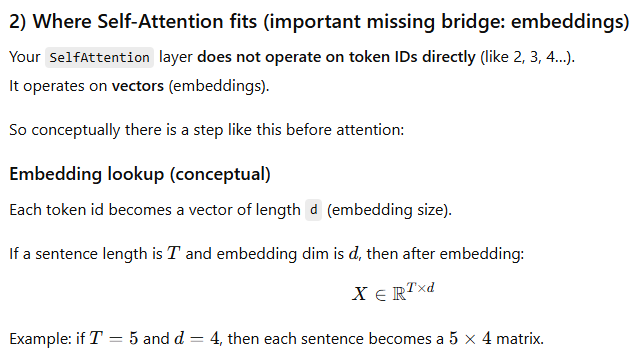

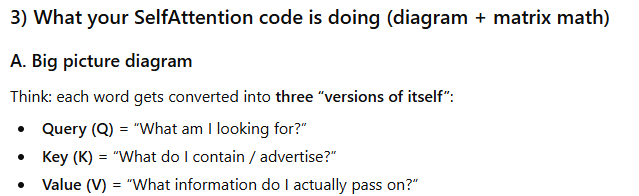

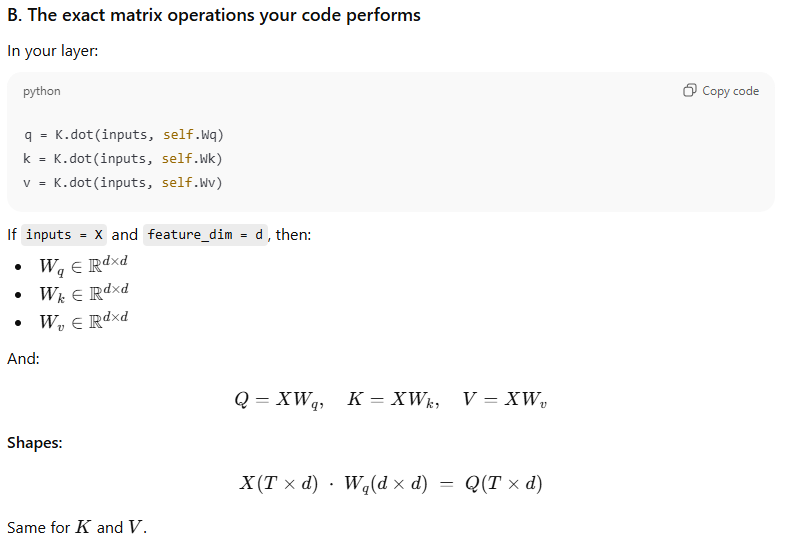

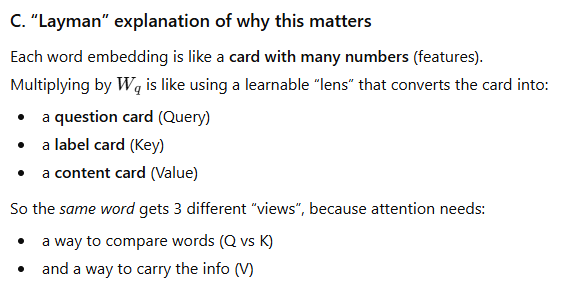
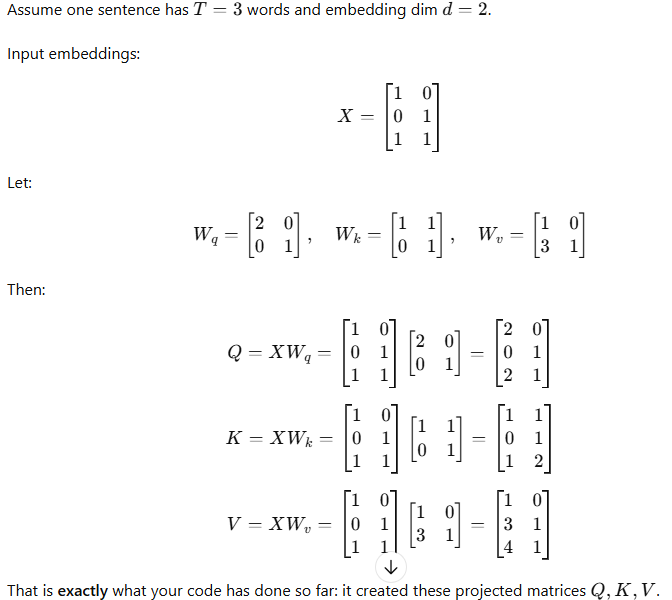

In [ ]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention: decoder attends to encoder outputs
attention = AdditiveAttention(use_scale=True)
attention_output = attention([decoder_outputs, encoder_outputs])

# Combine decoder outputs with attention context
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final Dense Layer
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 5, 256)    │      4,096 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 5, 256)    │      4,352 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 5, 256),  │    525,312 │ embedding_14[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 5, 256),  │    525,312 │ embedding_15[0][… │
│                     │ (None, 256),      │            │ lstm_14[0][1],    │
│                     │ (None, 256)]      │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 5, 256)    │        256 │ lstm_15[0][0],    │
│ (AdditiveAttention) │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 5, 512)    │          0 │ lstm_15[0][0],    │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5, 17)     │      8,721 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,068,049 (4.07 MB)

 Trainable params: 1,068,049 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

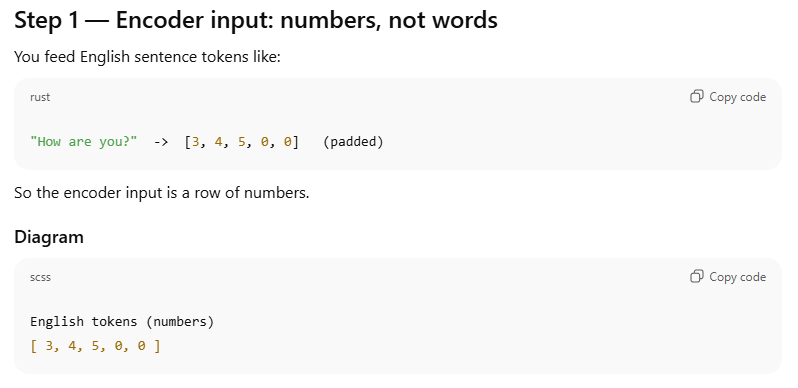
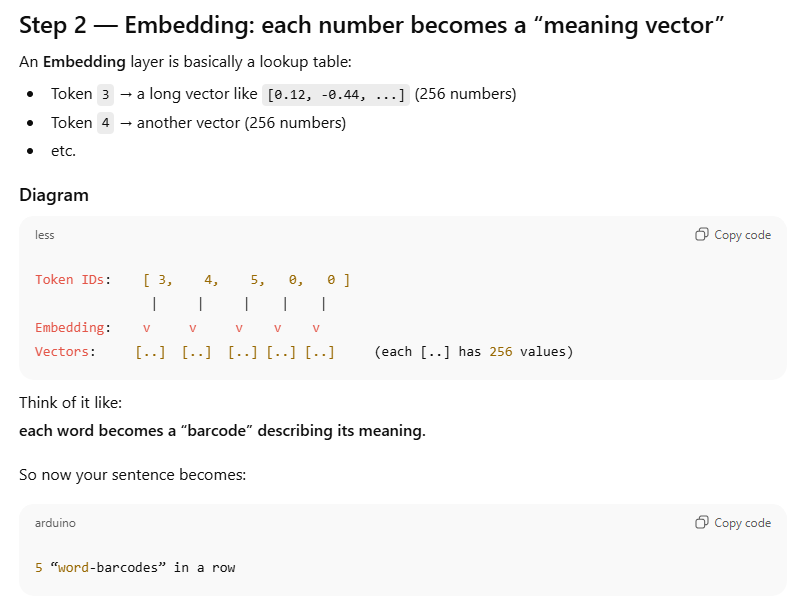
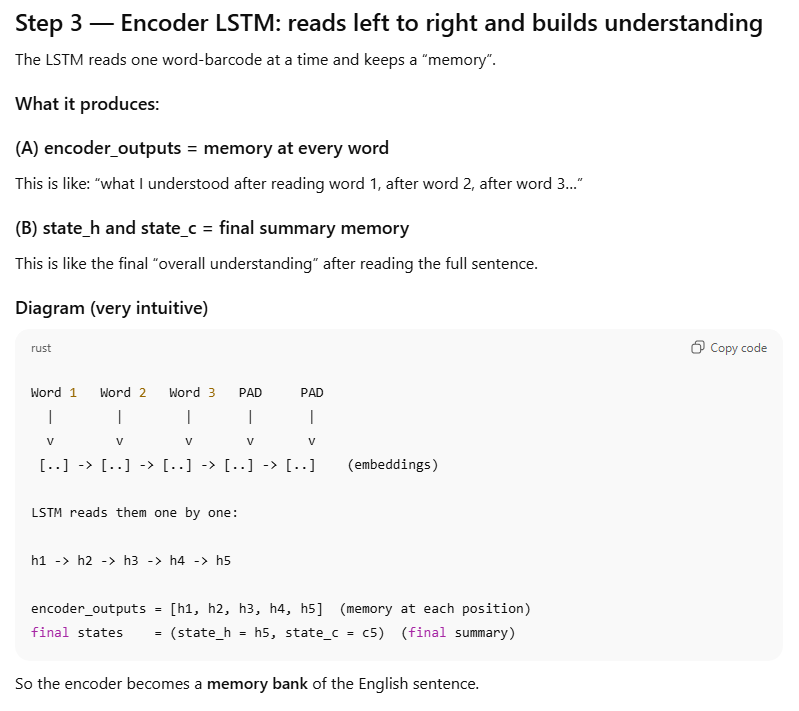
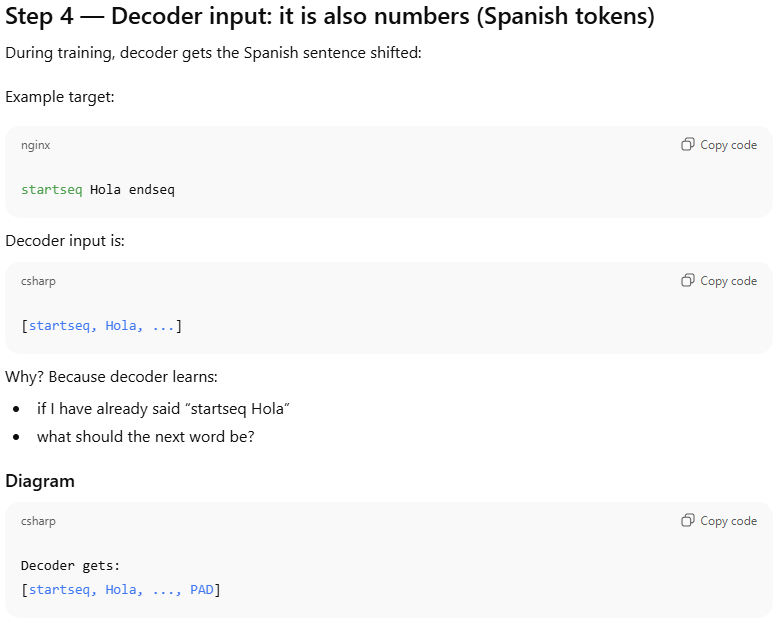
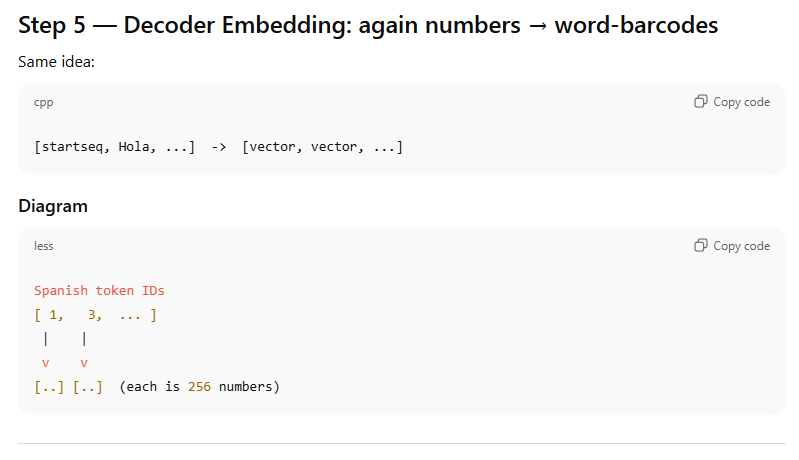
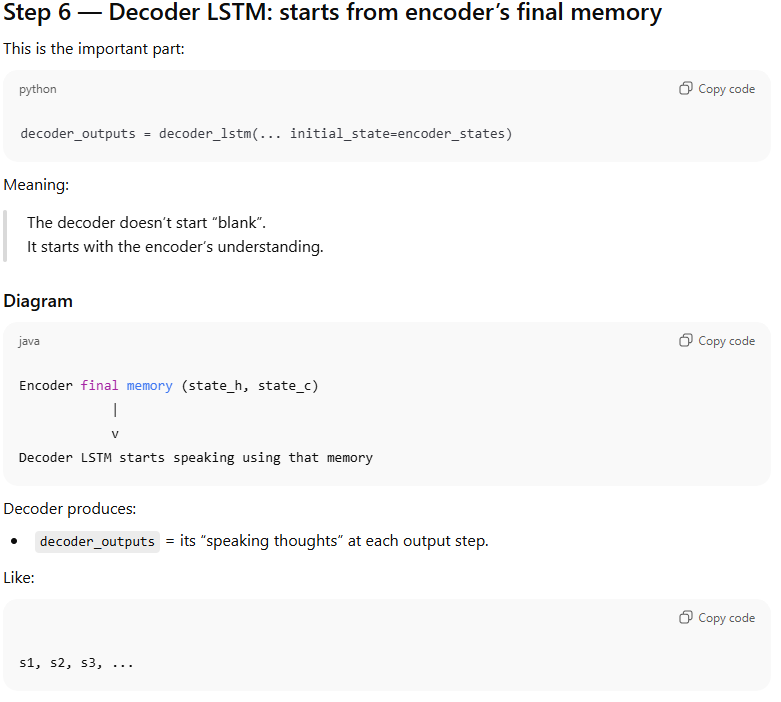

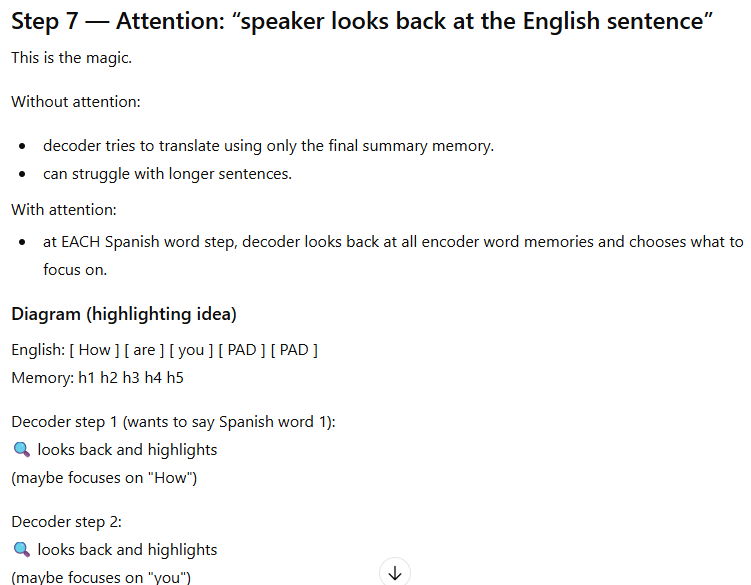
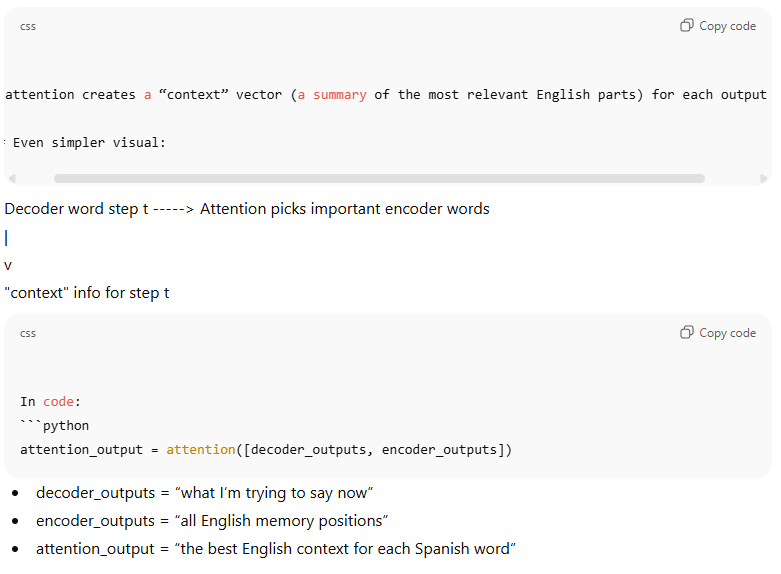
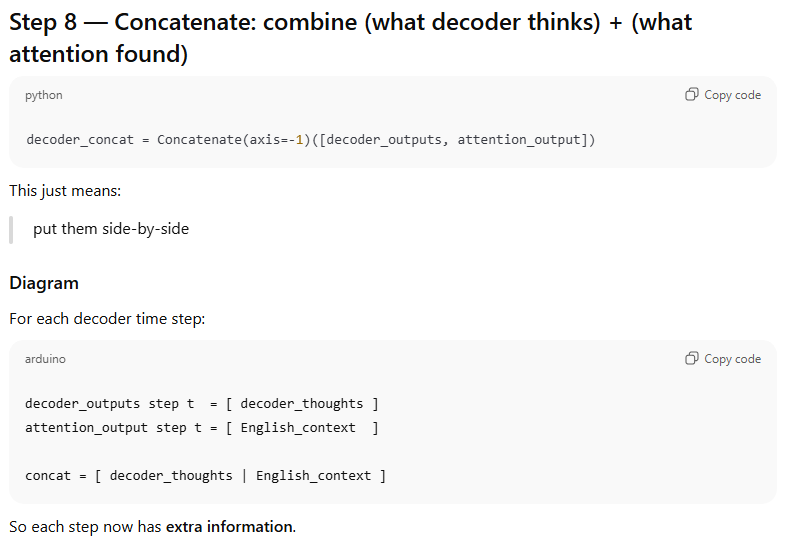
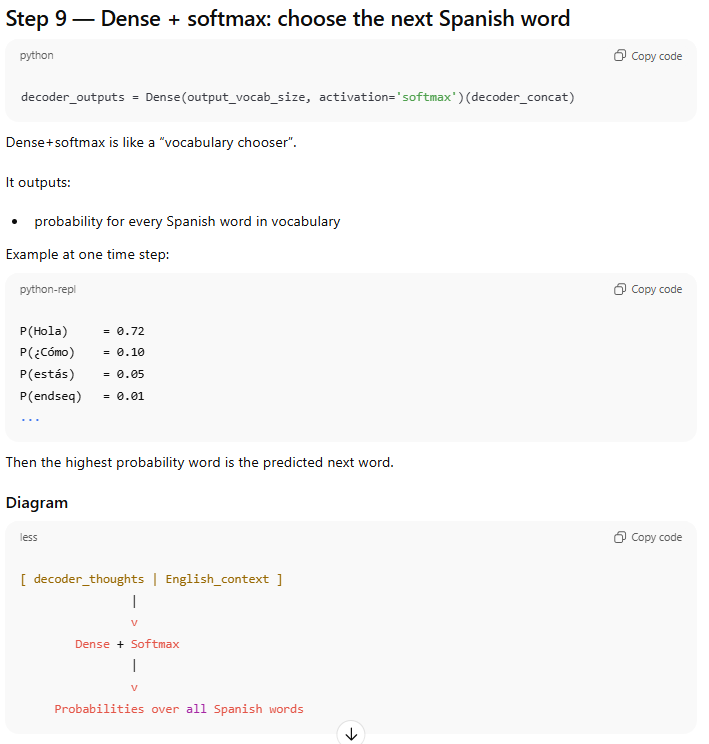
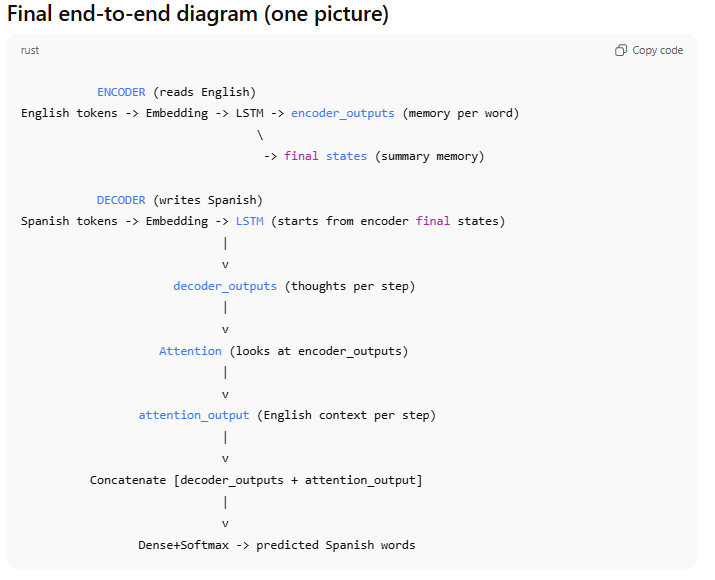

In [ ]:
# Training the model
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0400 - loss: 2.8318
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3600 - loss: 2.8008
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3200 - loss: 2.7679
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.3200 - loss: 2.7303
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.3200 - loss: 2.6846
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3200 - loss: 2.6266
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.3200 - loss: 2.5509
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.3200 - loss: 2.4513
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2800 - loss: 2.3243
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.2400 - loss: 2.1828
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.2400 - loss: 2.0764
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.

<function matplotlib.pyplot.show(close=None, block=None)>

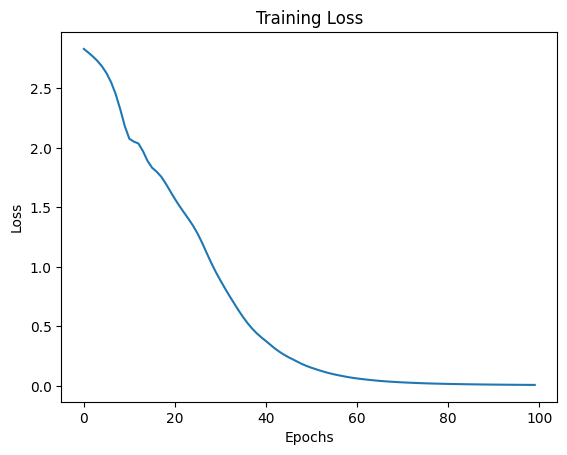

In [ ]:
# Plotting the training loss
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title(('Training Loss'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show



In [ ]:
# Define a special kind of layer for our neural network called SelfAttention

# This SelfAttention layer learns how to let each element in your input “look at”
# other elements and decide which ones matter more, then combines information accordingly.

#Think of your input as a row of items (words in a sentence, time steps in a
#signal, patches in an image). Attention helps each item say:
# “From all the other items, which should I pay attention to, and how much?”#

# Let's break down the SelfAttention class, line by line, focusing on the
# concepts of Query, Key, and Value, which are central to how self-attention works.

# The line below defines a custom neural network layer named SelfAttention.
# It inherits from Keras's Layer class, which provides the foundational structure for custom layers in Keras.

# This is the constructor method for your SelfAttention layer. It's called
# when you create an instance of the layer (e.g., attention_layer = SelfAttention()).


# super(): This function calls the constructor of the parent class, which is Layer in this case.
# init(**kwargs): This ensures that any initialization logic defined in
# the Layer base class is executed. It also allows you to pass any general
# keyword arguments (like name for the layer) to the parent constructor.
# Purpose: At this stage, the layer is simply initialized; no weights are
# created yet, as their dimensions depend on the input shape.

class SelfAttention(Layer):

  def __init__(self, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)

  def build(self, input_shape):
    # This method is called automatically by Keras the very first time the layer
    # receives data (i.e., when you first pass an input tensor to it).
    # Purpose: Its main job is to create the layer's weights based on the input_shape.

    feature_dim = input_shape[-1]
    # input_shape: This argument is a tuple representing the shape of the input data
    # that the layer expects. For example, if your input is a batch of sequences,
    # input_shape might be (batch_size, sequence_length, embedding_dimension).
    # [-1]: This extracts the last element of the input_shape tuple.
    # In most sequence processing tasks (like NLP with embeddings), this last dimension
    # represents the feature dimension or the embedding size of each element in the sequence.
    # This feature_dim determines the size of our Query, Key, and Value vectors.


    self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='he_uniform',
                              trainable=True,
                              name='Wq')

    self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='he_uniform',
                              trainable=True,
                              name='Wk')

    self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='he_uniform',
                              trainable=True,
                              name='Wv')


    # self.Wq/Wk/Wv: This creates a weight matrix specifically for transforming the input into a Query representation.
    # self.add_weight(): This is a Keras utility function to create a trainable weight variable for the layer.
    # shape=(feature_dim, feature_dim): This defines the shape of the weight matrix.
    # It's a square matrix, meaning it will transform an input vector of feature_dim
    # into an output vector also of feature_dim. This ensures that Query, Key, and Value
    # vectors have the same dimensionality as the input features.
    # initializer='glorot_uniform': This specifies how the values in Wq/Wk/Wv are
    # initialized at the beginning of training. 'Glorot uniform' (also known as Xavier uniform)
    # is a common and effective initialization strategy for neural network weights.
    # trainable=True: This tells Keras that this weight matrix should be updated and learned during the model's training process.
    # name='Wq/Wk/Wv': This assigns a descriptive name to the weight matrix, useful for debugging.

    super(SelfAttention, self).build(input_shape)

    # super(SelfAttention, self).build(input_shape): Calls the build method of
    # the parent Layer class, completing the build process.
    # Key Insight: At the end of build, we have three distinct, trainable weight matrices
    # (Wq, Wk, Wv). These matrices will be used to project the same input into
    # three different conceptual spaces: Query, Key, and Value.

  def call(self, inputs):

    q = K.dot(inputs, self.Wq)
    k = K.dot(inputs, self.Wk)
    v = K.dot(inputs, self.Wv)

    # This is the core logic of the layer. It defines how the layer processes its
    # input (inputs) during the forward pass of the network.

    # q = K.dot(inputs, self.Wq):
    # inputs: This is the input tensor that the SelfAttention layer receives.
    # For example, if you have a sentence, this might be a matrix where each row
    # is the embedding of a word in that sentence.
    # self.Wq: This is the Query weight matrix we created in the build method.
    # K.dot(inputs, self.Wq): This performs a matrix multiplication (dot product)
    # between your inputs and the self.Wq matrix.
    # Result q (Query): The output q is a tensor where each element (e.g., each word's embedding)
    # in the original inputs has been transformed into a Query vector.
    # A Query vector conceptually asks, "What information am I looking for from other parts of the sequence?"
    # or "How relevant is other information to me?"

    # k = K.dot(inputs, self.Wk):
    # Similar to the Query, this performs a matrix multiplication between the
    # same inputs and the self.Wk (Key) weight matrix.
    # Result k (Key): The output k is a tensor where each element from inputs
    # has been transformed into a Key vector.
    # A Key vector represents the information that an element has to offer for comparison.
    # It answers the implicit question, "Here's what I am, or here's what I contain, for others to query."

    # v = K.dot(inputs, self.Wv):
    # Again, this performs a matrix multiplication between the inputs and the self.Wv (Value) weight matrix.
    # Result v (Value): The output v is a tensor where each element from inputs has been transformed into a Value vector.
    # A Value vector contains the actual content or information that will be passed
    # along if an element is deemed relevant. It's the "payload" of the attention mechanism.

In [ ]:
# Training the model
history_he= model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0080
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0077
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0075
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0073
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0071
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0070
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0068
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0066
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0063
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0062
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.000

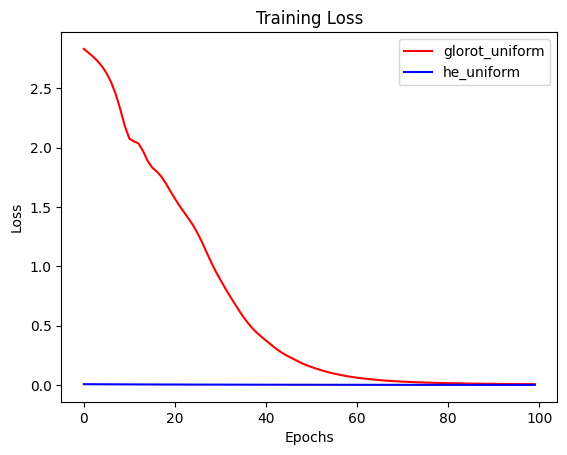

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 0.0018
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - l

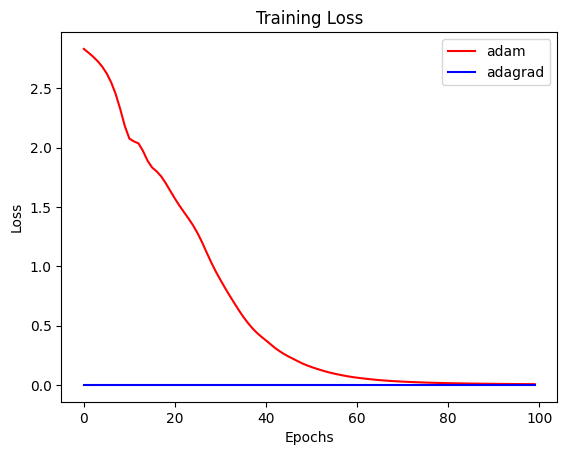

In [ ]:
#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_adagrad = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="adam", color='red')
plt.plot(history_adagrad.history['loss'], label="adagrad", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()